In [ ]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy import signal
(x_train_c, y_train_c), (x_test_c, y_test_c) = keras.datasets.cifar10.load_data()
(x_train_m, y_train_m), (x_test_m, y_test_m) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Submatrix function that extracts a small submatrix of given size at given position.

def submatrix(matrix, startRow, startCol, size):
  return matrix[(startRow):(startRow+size), (startCol):(startCol+size)]

In [ ]:
# Function to rotate a kernel 180 degrees, used for backpropagation

def rotate(input_matrix, X, Y, output):
    for i in range(X):
        for j in range(Y):
            output[i, Y-1-j] = input_matrix[X-1-i, j]

In [ ]:
# Convololution function that takes either a single 2D or 3D image as input_matrix, and either a single kernel or 
# multiple kernels as input_kernels and returns a stack of feature maps equal to the amount of kernels.


def Convolution(input_matrix, input_kernels, mode):

# Checks whether a single kernel is used or multiple and changes the values used in the loops and output size accordingly.
  if (input_kernels.ndim == 3):
    kerneldepth = len(input_kernels)
    kernel_size = len(input_kernels[0])
  else:
    kerneldepth = 1
    kernel_size = len(input_kernels)

# Checks whether a 2D or 3D image is used and changes the values used in the loops and output size accordingly.
  if input_matrix.ndim == 2:
    depth = 1
    input_height, input_width = input_matrix.shape
  else:
    input_height, input_width, depth = input_matrix.shape

# Creates empty arrays for the outputs
  if mode == "valid":
    final_output_size = (kerneldepth, input_height - kernel_size + 1, input_width - kernel_size + 1)
    final_output = np.zeros(final_output_size)
    output_shape = (input_height - kernel_size + 1, input_width - kernel_size + 1)
    final_final_output = np.zeros(output_shape)
  if mode == "padded":
    final_output_size = (kerneldepth, input_height - kernel_size + 5, input_width - kernel_size + 5)
    final_output = np.zeros(final_output_size)
    output_shape = ((input_height - kernel_size) + 5, (input_width - kernel_size) + 5)
    final_final_output = np.zeros(output_shape)

# Loops over all the kernels and the depth of the image
  for j in range(kerneldepth):
    for i in range(depth):

      # Selects kernel and image to be used
      output = np.zeros(output_shape)
      kernel = input_kernels[j]
      if depth == 1:
        image = input_matrix
      else:
          image = input_matrix[:,:,i]
      Yimage, Ximage = image.shape
      if mode == "valid":

        new_image = np.zeros((input_height - kernel_size + 1, input_width - kernel_size + 1))
      if (mode == "padded"):

        output_image =  np.zeros((Yimage + 2, Ximage +2 ))
        new_image = np.zeros((Yimage + 2, Ximage + 2))
        for x in range(Ximage):
          for y in range(Yimage):
            new_image[x+1,y+1] = image[x,y]


      # Loops over the image, selecting a submatrix and multiplying it with the kernel, adding tha result to the new image
      for x in range(Ximage):
        for y in range(Yimage):
          if (x+kernel_size <= Ximage and y+kernel_size <= Yimage):
            if mode == "valid":
              sub = submatrix(image, x, y, kernel_size)
            if mode == "padded":
              sub = submatrix(new_image, x, y, kernel_size)
            mulitply = np.multiply(kernel,sub)
            add = np.sum(mulitply)
            if mode == "valid":
              new_image[x,y] = add
            if mode == "padded":
              output_image[x,y] = add
      # Adds the multiple multiple feature maps of the 3D images into a single feature map
      if mode == "valid":
        output += new_image
      if mode == "padded":
        output += output_image
    final_output[j] = output
  if (kerneldepth == 1):
    final_output = final_output[0]
  return final_output

In [ ]:
# Relu activation function that takes a single feature map as input and ensures that all negative numbers become 0
# Returns the non-negative feature map

def relu(input_matrix):  
  output_shape = (input_matrix.shape[0], input_matrix.shape[1])
  output = np.zeros(output_shape)
  for i in range(input_matrix.shape[0]):
    output[i] = np.maximum(0,input_matrix[i])
  return output

In [ ]:
# Normalise function that takes a single feature map as input and outputs the normalised feature map. 

def normalize(input_matrix):
  matrix = input_matrix
  matrix = matrix - matrix.mean()
  output = matrix/matrix.std()
  return output

In [ ]:
# Softmax function that takes the output from the dense layer and returns the probabilities. 
# Converts the activation of the dense layer into probabilities 

def softmax(layer):
  soft = np.exp(layer)/sum(np.exp(layer))
  return soft

In [ ]:
# Code for one hot encoding, used by the the self-made convolutional neural network
# in order to calculate the derivative of the input of the final layer.

y_true = y_train_m
total_numbers = [0,1,2,3,4,5,6,7,8,9]

mapping = {}
for x in range(len(total_numbers)):
  mapping[total_numbers[x]] = x

one_hot_encode = []

for c in y_true:
  arr = list(np.zeros(len(total_numbers), dtype = int))
  arr[mapping[c]] = 1
  one_hot_encode.append(arr)

In [ ]:
# Backpropagation function with the derivative of the filter in the next layer, the current layer inputs and current filter as inputs
# and outputs the derivative of the filters in the current layer and the derivative of the input of the current layer. 
# The derivative of the filters of the current layer is used to update the filters while the derivative of teh current layer input is used
# to backpropagate to the previous layer.

def backpropagation(derivative_filters_next_layer, current_layer_input, current_filter):

  # The kernel has to be rotated 180 degree to calculate the derivative of the current layer inputs, which is a padded version of the convolution operation.
  rotated_kernel = current_filter.copy()
  rotate(current_filter, 3, 3, rotated_kernel)
  
  # Uses the convolution operation to calculate the derivatives, one without padding for the derivative of the current layer and once padded for the derivative of the current input layer.
  derivative_filters_current_layer = Convolution(current_layer_input, derivative_filters_next_layer, "valid")
  derivative_current_layer_input = Convolution(derivative_filters_next_layer, rotated_kernel, "padded")

  return derivative_filters_current_layer, derivative_current_layer_input

In [ ]:
# Fully-connected layer that takes a single matrix and output size as inputs, and outputs the weights and a final layer.

def dense_layer2(matrix, outputsize):
  flat = matrix.flatten()
  layer = np.zeros((outputsize))
  
  # Takes the dot product of the weights and the flattened input matrix
  for i in range(outputsize):
    layer[i] = np.dot(weights[:, i], flat)
    
  return layer

In [ ]:
# Stochastic gradient descent
# Preset kernels
first_layer_kernels = np.random.uniform(-3,3,[3,3])
second_layer_kernels = np.random.uniform(-3,3,[3,3])


# Initalizing variables
learning_rate = 0.01
weight_der = np.zeros((576,10))
correct = 0
total_validation_correct = []
epochs = 20
train_batch = int(60000/ epochs)
test_batch = int(10000/ epochs)
total_correct = []

# Initializing weights
weights = np.zeros((576,10))
for x in range(576):
  for y in range(10):
    weights[x,y] = random.uniform(0.1,0.3)


# Start training convolutional neural network
for j in range(epochs):
  validation_correct = 0
  correct = 0
  for i in range(train_batch):
    # Forward pass for training data
    first_layer_output = signal.correlate2d(x_train_m[train_batch * j + i], first_layer_kernels, "valid")
    first_relu_layer = relu(first_layer_output)
    first_norm_layer = normalize(first_relu_layer)

    second_layer_output = signal.correlate2d(first_norm_layer, second_layer_kernels, "valid")
    second_relu_layer = relu(second_layer_output)
    second_norm_layer = normalize(second_relu_layer)

    dense_layer = dense_layer2(second_norm_layer, 10)
    soft_layer = softmax(dense_layer)
    der = soft_layer - one_hot_encode[train_batch * j + i]
    if soft_layer.argmax() == y_train_m[train_batch * j + i]:
      correct += 1

    # Backwards pass, updating weights
    weight_der = np.dot(second_norm_layer.reshape(-1,1), der.reshape(1,-1))
    weights -= learning_rate * weight_der
    input_derivatives = np.dot(weights, der.transpose())
    
    # Backpropagation of second layer, updating second layer filter
    reshaped_input_derivatives = input_derivatives.reshape(24,24)
    derivative_filters_current_layer, derivative_current_layer_input = backpropagation(reshaped_input_derivatives, first_norm_layer, second_layer_kernels)
    second_layer_kernels -= learning_rate * derivative_filters_current_layer

    # Backpropagation of first layer, updating first layer filter
    derivative_filters_current_layer, derivative_current_layer_input = backpropagation(derivative_current_layer_input, x_train_m[train_batch * j + i], first_layer_kernels)
    first_layer_kernels -= learning_rate * derivative_filters_current_layer

  # Forward pass of test data
  print(correct)
  for i in range(test_batch):
    test_first_layer_output = signal.correlate2d(x_test_m[test_batch * j + i], first_layer_kernels, "valid")
    test_first_relu_layer = relu(test_first_layer_output)
    test_first_norm_layer = normalize(test_first_relu_layer)

    test_second_layer_output = signal.correlate2d(test_first_norm_layer, second_layer_kernels, "valid")
    test_second_relu_layer = relu(test_second_layer_output)
    test_second_norm_layer = normalize(test_second_relu_layer)

    test_dense_layer = dense_layer2(test_second_norm_layer, 10)
    test_soft_layer = softmax(test_dense_layer)
    if test_soft_layer.argmax() == y_test_m[test_batch * j + i]:
      validation_correct += 1
  total_correct.append(correct)
  total_validation_correct.append(validation_correct)
  print("epoch: " + str(j) + " " + "correct: " + str(correct) + " " +  "validation_correct: " + str(validation_correct))


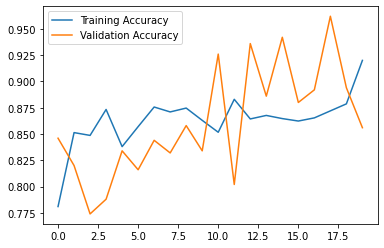

In [ ]:
accuracy = [x / train_batch for x in total_correct]
val_accuracy = [x / test_batch for x in total_validation_correct]
plt.figure()
plt.plot(accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.legend()

In [ ]:
# Mini-batch gradient descent
# Preset kernels
first_layer_kernels = np.random.uniform(-1,1,[3,3])
second_layer_kernels = np.random.uniform(-1,1,[3,3])


# Initalizing variables
learning_rate = 0.00001
weight_der = np.zeros((576,10))
epochs = 20
train_batch = int(60000/ epochs)
test_batch = int(10000/ epochs)
total_correct = []
total_validation_correct = []

# Initializing weights
weights = np.zeros((576,10))
for x in range(576):
  for y in range(10):
    weights[x,y] = random.uniform(0.1,0.2)
    

# Start training convolutional neural network
for j in range(epochs):
  validation_correct = 0
  correct = 0
  derivative_filters_second_layer_total = 0
  derivative_second_layer_input_total = 0
  derivative_filters_first_layer_total = 0
  for i in range(train_batch):
    # Forward pass for training data
    first_layer_output = signal.correlate2d(x_train_m[test_batch * j + i], first_layer_kernels, "valid")
    first_relu_layer = relu(first_layer_output)
    first_norm_layer = normalize(first_relu_layer)

    second_layer_output = signal.correlate2d(first_norm_layer, second_layer_kernels, "valid")
    second_relu_layer = relu(second_layer_output)
    second_norm_layer = normalize(second_relu_layer)

    dense_layer = dense_layer2(second_norm_layer, 10)
    soft_layer = softmax(dense_layer)
    der = soft_layer - one_hot_encode[test_batch * j + i]
    if soft_layer.argmax() == y_train_m[test_batch * j + i]:
      correct += 1

    # Backwards pass
    weight_der += np.dot(second_norm_layer.reshape(-1,1), der.reshape(1,-1))

    # Backpropagation of second layer, updating second layer filter
    input_derivatives = np.dot(weights, der.transpose())
    reshaped_input_derivatives = input_derivatives.reshape(24,24)
    derivative_filters_current_layer, derivative_current_layer_input = backpropagation(reshaped_input_derivatives, first_norm_layer, second_layer_kernels)
    derivative_filters_second_layer_total += derivative_filters_current_layer

    # Backpropagation of first layer, updating first layer filter
    derivative_filters_current_layer, derivative_current_layer_input = backpropagation(derivative_current_layer_input, x_train_m[test_batch * j + i], first_layer_kernels)
    derivative_filters_first_layer_total += derivative_filters_current_layer

  # Updating weights and kernels
  weights -= learning_rate * weight_der
  second_layer_kernels -= learning_rate * derivative_filters_second_layer_total
  first_layer_kernels -= learning_rate * derivative_filters_first_layer_total


  # Forward pass of test data
  for i in range(test_batch):
    index = test_batch * j + i
    test_first_layer_output = signal.correlate2d(x_test_m[test_batch * j + i], first_layer_kernels, "valid")
    test_first_relu_layer = relu(test_first_layer_output)
    test_first_norm_layer = normalize(test_first_relu_layer)

    test_second_layer_output = signal.correlate2d(test_first_norm_layer, second_layer_kernels, "valid")
    test_second_relu_layer = relu(test_second_layer_output)
    test_second_norm_layer = normalize(test_second_relu_layer)

    test_dense_layer = dense_layer2(test_second_norm_layer, 10)
    test_soft_layer = softmax(test_dense_layer)
    if test_soft_layer.argmax() == y_test_m[test_batch * j + i]:
      validation_correct += 1
  total_correct.append(correct)
  total_validation_correct.append(validation_correct)
  print("epoch: " + str(j) + " " + "correct: " + str(correct) + " " +  "validation_correct: " + str(validation_correct))

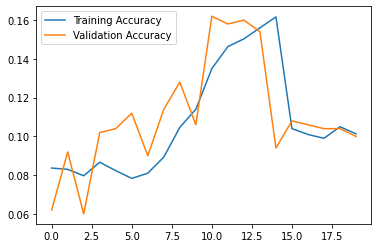

In [ ]:
# For mini-batch gradient descent, the derivative with which the kernels were updated were too high, causing the kernels to become an infinite negative number, which caused the sudden drop at epoch 13.
# Due to a lack of time I did not have enough time to debug this part.

accuracy = [x / train_batch for x in total_correct]
val_accuracy = [x / test_batch for x in total_validation_correct]
plt.figure()
plt.plot(accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.legend()